In [1]:
import pandas as pd
import numpy as np
import numpy as np
from cvxopt import matrix, solvers
import matplotlib.pyplot as plt
import yfinance as yf

In [2]:
#import actual and predicted prices
actual_prices = pd.read_csv('actual_prices_1.csv')
actual_prices['Date'] = pd.to_datetime(actual_prices['Date'])
actual_prices = actual_prices.set_index('Date')
predicted_prices = pd.read_csv('predicted_prices_1.csv')
predicted_prices['Date'] = pd.to_datetime(predicted_prices['Date'])
predicted_prices = predicted_prices.set_index('Date')

In [3]:
actual_prices['2021':]

,AAPL,AMZN,BRK-B,GOOG,GOOGL,JNJ,MSFT,TSLA,UNH,XOM
Date,,,,,,,,,,
2021-01-04,128.087082,159.331497,228.449997,86.412003,86.306503,149.704880,214.479111,243.256668,341.344971,37.906910
2021-01-05,129.670700,160.925507,227.470001,87.045998,87.002502,151.465012,214.686005,245.036667,336.754639,39.733746
2021-01-06,125.305794,156.919006,230.270004,86.764503,86.143997,152.890320,209.119324,251.993332,350.886993,40.747643
2021-01-07,129.581650,158.108002,232.880005,89.362503,88.717003,153.406876,215.070251,272.013336,356.512634,41.067341
2021-01-08,130.700089,159.134995,234.029999,90.360497,89.891502,153.091202,216.380646,293.339996,354.910950,41.524048
...,...,...,...,...,...,...,...,...,...,...
2022-07-12,145.657669,109.220001,277.279999,114.849503,114.020500,174.676346,253.132690,233.070007,512.810913,83.686874
2022-07-13,145.288193,110.400002,277.470001,112.186996,111.353500,174.269089,252.184708,237.039993,499.672150,84.023605
2022-07-14,148.264053,110.629997,274.410004,111.440002,110.367500,174.507477,253.541840,238.313339,500.858429,82.339966


# MVT portfolio

In [4]:
def port(mu, Q, tau):
    """
    This function return the optimal weights
    """
    n = len(mu)
    
    #matrix Gx <=h
    G = matrix(np.concatenate((-np.eye(n,n),np.eye(n,n)))) 
    h = matrix(np.concatenate((np.zeros(n),np.zeros(n)+0.5)))
    
    #matrix Ax = b
    A = matrix(np.ones(n)).T
    b = matrix([1.0])
    
    #get vector h that maximizes function U
    mu_temp = matrix(-tau*mu)
    sol = solvers.qp(Q,mu_temp,G,h,A,b)
    
    return sol['x']

In [5]:
#get actual and predicted return
pred_return = predicted_prices['2021':].pct_change()
act_return = actual_prices['2021':].pct_change()

In [6]:
#get mean and covariance of predicted returns
pred_mu = matrix(pred_return.mean())
pred_var = matrix(pred_return.cov().values)

In [7]:
#optimal weights
h = port(pred_mu,pred_var,0.5)
#optimal daily returns
opt_return = np.array((matrix(act_return.dropna().values)*h))

     pcost       dcost       gap    pres   dres
 0: -9.2751e-05 -5.3014e+00  5e+00  4e-16  4e-16
 1: -9.2871e-05 -5.5549e-02  6e-02  2e-16  3e-16
 2: -1.0394e-04 -2.9979e-03  3e-03  2e-16  1e-17
 3: -3.5461e-04 -1.0311e-03  7e-04  1e-16  4e-19
 4: -4.1666e-04 -5.4723e-04  1e-04  2e-16  6e-19
 5: -4.6330e-04 -4.7184e-04  9e-06  2e-16  3e-19
 6: -4.6643e-04 -4.6652e-04  9e-08  2e-16  2e-19
Optimal solution found.


In [8]:
opt_return = pd.DataFrame(opt_return,index = pred_return.dropna().index,columns=['Return'])
opt_return

,Return
Date,
2021-01-05,0.013843
2021-01-06,-0.007732
2021-01-07,0.025090
2021-01-08,0.010659
2021-01-11,-0.008491
...,...
2022-07-12,-0.022178
2022-07-13,-0.012033
2022-07-14,-0.006758


In [9]:
#cumulative return
opt_cum_return = np.cumprod(1+opt_return)-1

In [10]:
opt_cum_return

,Return
Date,
2021-01-05,0.013843
2021-01-06,0.006005
2021-01-07,0.031245
2021-01-08,0.042237
2021-01-11,0.033388
...,...
2022-07-12,0.447691
2022-07-13,0.430271
2022-07-14,0.420605


# Benchmarks

### Equal weighted portfolio

In [11]:
#equal weighted
h_e = matrix(np.ones((10,1))*0.1)
#equal weighted daily returns
ew_return = np.array((matrix(act_return.dropna().values)*h_e))

In [12]:
ew_return = pd.DataFrame(ew_return,index = pred_return.dropna().index,columns=['Return'])
ew_return

,Return
Date,
2021-01-05,0.008826
2021-01-06,0.002000
2021-01-07,0.024801
2021-01-08,0.013354
2021-01-11,-0.016185
...,...
2022-07-12,-0.012753
2022-07-13,-0.004826
2022-07-14,-0.000952


In [13]:
#cumulative return
ew_cum_return = np.cumprod(1+ew_return)-1
ew_cum_return

,Return
Date,
2021-01-05,0.008826
2021-01-06,0.010844
2021-01-07,0.035914
2021-01-08,0.049748
2021-01-11,0.032757
...,...
2022-07-12,0.278318
2022-07-13,0.272148
2022-07-14,0.270938


### S&P500

In [14]:
start = act_return.index[0]
end = '2022-07-19'

spy = yf.download('SPY',start,end)['Adj Close']
spy

[*********************100%***********************]  1 of 1 completed


Date
2021-01-04    359.773254
2021-01-05    362.251129
2021-01-06    364.416901
2021-01-07    369.831207
2021-01-08    371.938416
                 ...    
2022-07-12    379.272003
2022-07-13    377.280182
2022-07-14    376.363953
2022-07-15    383.554443
2022-07-18    380.387451
Name: Adj Close, Length: 387, dtype: float64

In [15]:
spy_cum_return = np.cumprod(1+spy.pct_change().dropna())-1
spy_cum_return

Date
2021-01-05    0.006887
2021-01-06    0.012907
2021-01-07    0.027956
2021-01-08    0.033813
2021-01-11    0.026845
                ...   
2022-07-12    0.054197
2022-07-13    0.048661
2022-07-14    0.046114
2022-07-15    0.066100
2022-07-18    0.057298
Name: Adj Close, Length: 386, dtype: float64

# Portfolio Evaluation

Given $100, our graph shows how much our portfolio value increase compare to benchmarks

In [16]:
opt_equity = [100]
ew_equity = [100]
spy_equity = [100]
for i in range(0,len(opt_cum_return)):
    opt_equity.append(100*(1+opt_cum_return.iloc[i].values[0]))
    ew_equity.append(100*(1+ew_cum_return.iloc[i].values[0]))
    spy_equity.append(100*(1+spy_cum_return.iloc[i]))

In [17]:
timestamp = spy.index

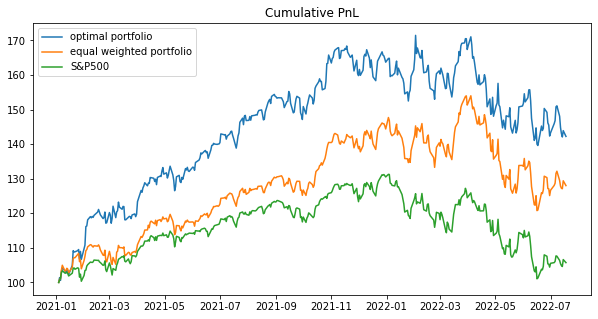

<Figure size 432x288 with 0 Axes>

In [18]:
plt.figure(figsize = (10,5))
plt.plot(timestamp, opt_equity,label = 'optimal portfolio')
plt.plot(timestamp,ew_equity, label = 'equal weighted portfolio')
plt.plot(timestamp,spy_equity,label = 'S&P500')
plt.title('Cumulative PnL')
plt.legend(loc='best')
plt.show()

#### Annulized Sharpe Ratio

In [28]:
#MVT portfolio
opt_sharpe = opt_return.mean()/opt_return.std()*(252**0.5)
#equal weighted portfoli
ew_sharpe = ew_return.mean()/ew_return.std()*(252**0.5)
#SP500
spy_sharpe = spy_return.mean()/spy_return.std()*(252**0.5)

### Results

In [35]:
#a dataframe representing the final performence metrics of MVT portfolio & benchmarks
results = pd.DataFrame({'Cumulative Returns':[opt_cum_return.iloc[-1].values[0],ew_cum_return.iloc[-1].values[0],
                                              spy_cum_return[-1]],
                        'Annualized Sharpe Ratio':[opt_sharpe.values[0],ew_sharpe.values[0],spy_sharpe]},
                      index = ['MVT','EW','SPY'])
results

,Cumulative Returns,Annualized Sharpe Ratio
MVT,0.422245,1.096210
EW,0.279961,0.884521
SPY,0.057298,0.292400
